# Donor retention project Ian Kimura

#### My objective is to predict which donors are likely to stop contributing based on historical data


In [1]:
import pandas as pd
from datetime import timedelta
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# read the dataset into a dataframe
df = pd.read_csv('/users/iankimura/Documents/DS_INTERN/usf_aa_giving_test.csv')
df.head()

,ACCOUNT_ID,contact_id,Deceased,gift_amount_m,hh_gift_amount,FY,gift_date,designation_name,type_gp
0,0013i0000243bmjAAA,0033i000024DCfLAAW,0.0,50000.0,50000.0,1978,1/1/1978,Father William Dunne Scholarship,Household Gift
1,0013i0000243bmjAAA,0033i000024EszaAAC,0.0,50000.0,0.0,1978,1/1/1978,Father William Dunne Scholarship,Household Gift
2,0013i000023HTCyAAO,0033i000024EbfIAAS,1.0,25.0,25.0,1980,12/21/1979,KUSF Program Underwriting,Household Gift
3,0013i0000243kC0AAI,0033i000024Eb2qAAC,0.0,120.0,0.0,1981,3/12/1981,School of Law Assembly,Household Gift
4,0013i000023Hj4sAAC,0033i000024EAhIAAW,0.0,10.0,10.0,1981,4/10/1981,The USF Fund,Household Gift


In [3]:
# change gift_date into datetime
df['gift_date'] = pd.to_datetime(df['gift_date'])
df.head()

,ACCOUNT_ID,contact_id,Deceased,gift_amount_m,hh_gift_amount,FY,gift_date,designation_name,type_gp
0,0013i0000243bmjAAA,0033i000024DCfLAAW,0.0,50000.0,50000.0,1978,1978-01-01,Father William Dunne Scholarship,Household Gift
1,0013i0000243bmjAAA,0033i000024EszaAAC,0.0,50000.0,0.0,1978,1978-01-01,Father William Dunne Scholarship,Household Gift
2,0013i000023HTCyAAO,0033i000024EbfIAAS,1.0,25.0,25.0,1980,1979-12-21,KUSF Program Underwriting,Household Gift
3,0013i0000243kC0AAI,0033i000024Eb2qAAC,0.0,120.0,0.0,1981,1981-03-12,School of Law Assembly,Household Gift
4,0013i000023Hj4sAAC,0033i000024EAhIAAW,0.0,10.0,10.0,1981,1981-04-10,The USF Fund,Household Gift


In [4]:
# days_since_first_donation feature
df['days_since_first_donation'] = df.groupby('contact_id')['gift_date'].transform(lambda x: (x - x.min()).dt.days)

In [5]:
# aggregate all the features into one row
dataset = df.groupby('contact_id').agg({
    'gift_amount_m': ['sum', 'mean', 'count'],  
    'gift_date': ['min', 'max'],  
    'days_since_first_donation': 'mean'  
}).reset_index()

In [6]:
# change the column names
dataset.columns = [
    'contact_id', 'total_donations', 'avg_gift_amount', 'donation_count',
    'first_gift_date', 'last_gift_date', 'avg_days_since_first_donation'
]
dataset.head()

,contact_id,total_donations,avg_gift_amount,donation_count,first_gift_date,last_gift_date,avg_days_since_first_donation
0,0033i000022eTVqAAM,250.0,250.0,1,2014-12-31,2014-12-31,0.0
1,0033i000022eTvXAAU,81.0,40.5,2,2008-09-10,2009-12-31,238.5
2,0033i000022eTvYAAU,200.0,200.0,1,2002-10-11,2002-10-11,0.0
3,0033i000022eTvcAAE,50.0,50.0,1,1994-02-17,1994-02-17,0.0
4,0033i000022eTvfAAE,650.0,130.0,5,2007-02-14,2012-04-20,740.2


In [7]:
# only donators that are greater than 3
dataset = dataset[dataset['donation_count'] >= 3]
dataset.head()

,contact_id,total_donations,avg_gift_amount,donation_count,first_gift_date,last_gift_date,avg_days_since_first_donation
4,0033i000022eTvfAAE,650.0,130.000000,5,2007-02-14,2012-04-20,740.200000
6,0033i000022eTvqAAE,850.0,47.222222,18,1986-04-15,2023-01-26,9307.111111
10,0033i000022eTw4AAE,14465.0,904.062500,16,1985-05-03,2008-05-22,6214.750000
11,0033i000022eTw7AAE,200.0,40.000000,5,2001-09-20,2006-11-14,883.200000
12,0033i000022eTwBAAU,1405.0,82.647059,17,2005-03-11,2022-02-17,2863.647059


In [8]:
# how recent the last gift was
today = pd.to_datetime('today')  # Today's date
dataset['recency'] = (today - dataset['last_gift_date']).dt.days
dataset.head()

,contact_id,total_donations,avg_gift_amount,donation_count,first_gift_date,last_gift_date,avg_days_since_first_donation,recency
4,0033i000022eTvfAAE,650.0,130.000000,5,2007-02-14,2012-04-20,740.200000,4535
6,0033i000022eTvqAAE,850.0,47.222222,18,1986-04-15,2023-01-26,9307.111111,602
10,0033i000022eTw4AAE,14465.0,904.062500,16,1985-05-03,2008-05-22,6214.750000,5964
11,0033i000022eTw7AAE,200.0,40.000000,5,2001-09-20,2006-11-14,883.200000,6519
12,0033i000022eTwBAAU,1405.0,82.647059,17,2005-03-11,2022-02-17,2863.647059,945


In [17]:
# my target variable defining someone who stopped donating
# target set on donor who hasn't donated in 3 years
three_years = timedelta(days=365.25 * 3)
dataset['target'] = dataset['last_gift_date'].apply(lambda x: 1 if (today - x) >= three_years else 0)
dataset.head(10)

,contact_id,total_donations,avg_gift_amount,donation_count,first_gift_date,last_gift_date,avg_days_since_first_donation,recency,target
4,0033i000022eTvfAAE,650.0,130.000000,5,2007-02-14,2012-04-20,740.200000,4535,1
6,0033i000022eTvqAAE,850.0,47.222222,18,1986-04-15,2023-01-26,9307.111111,602,0
10,0033i000022eTw4AAE,14465.0,904.062500,16,1985-05-03,2008-05-22,6214.750000,5964,1
11,0033i000022eTw7AAE,200.0,40.000000,5,2001-09-20,2006-11-14,883.200000,6519,1
12,0033i000022eTwBAAU,1405.0,82.647059,17,2005-03-11,2022-02-17,2863.647059,945,0
13,0033i000022eTwNAAU,150.0,50.000000,3,1996-05-13,1998-12-31,454.000000,9394,1
14,0033i000022eTwRAAU,365.0,36.500000,10,2004-04-19,2009-12-01,764.500000,5406,1
16,0033i000022eTwZAAU,2675.0,72.297297,37,1981-12-22,2016-12-14,6480.513514,2836,1
18,0033i000022eTwhAAE,275.0,34.375000,8,1986-04-18,2008-12-19,4390.375000,5753,1
20,0033i000022eTwjAAE,75.0,25.000000,3,2002-11-06,2005-11-09,635.333333,6889,1


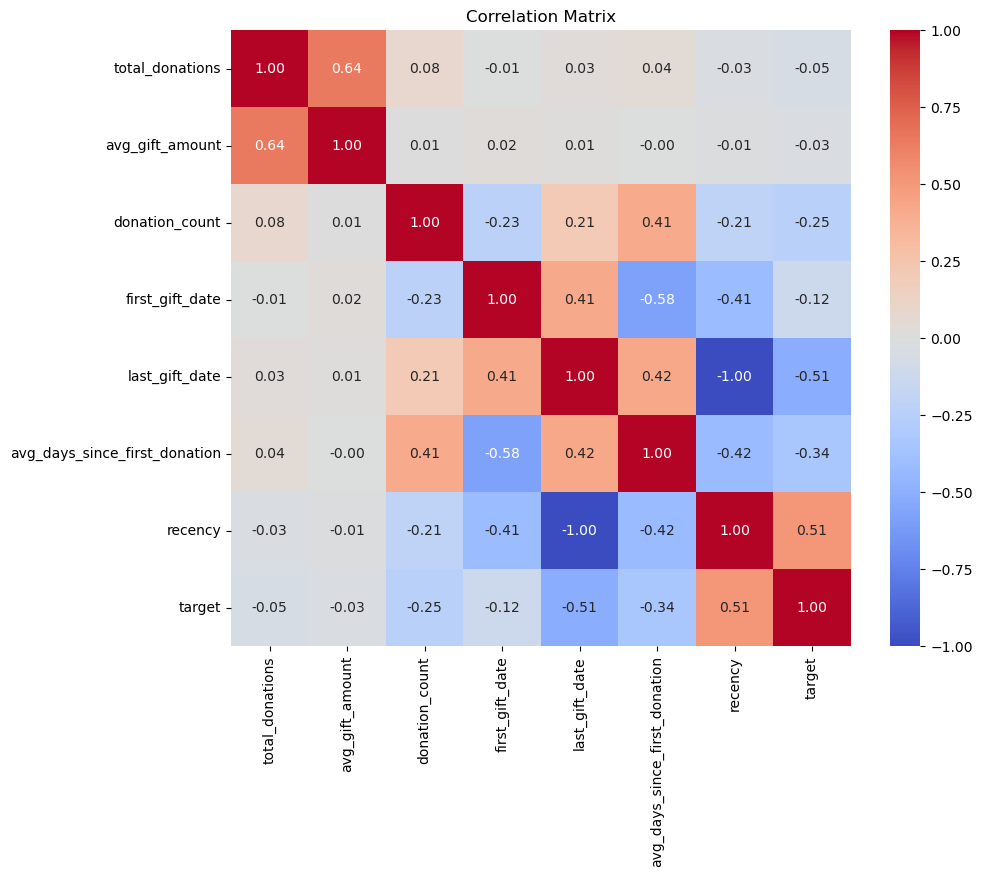

In [10]:
# correlation matrix
numeric_columns = dataset.select_dtypes(include=[float, int, 'datetime']).copy()
corr_matrix = numeric_columns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [11]:
# assigning my features
features = ['total_donations', 'avg_gift_amount', 'donation_count', 'recency', 'avg_days_since_first_donation']
X = dataset[features]
y = dataset['target']
# avg_days_between_gifts
# slope
# take out recency/avg_days_since
# last_gift_date
# first_gift_date

In [12]:
# splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
# scale my data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# fit my model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [15]:
# apply onto the test set
y_pred = model.predict(X_test)

In [16]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.00
[[ 2369     0]
 [   38 11636]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2369
           1       1.00      1.00      1.00     11674

    accuracy                           1.00     14043
   macro avg       0.99      1.00      1.00     14043
weighted avg       1.00      1.00      1.00     14043

